# Toxic Comment Classification Challenge

Identify and classify toxic online comments

Build a multi-headed model that’s capable of detecting different types of of toxicity like threats, obscenity, insults, and identity-based hate better than Perspective’s current models. You’ll be using a dataset of comments from Wikipedia’s talk page edits. Improvements to the current model will hopefully help online discussion become more productive and respectful.

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras import optimizers
from keras.models import Model, load_model
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from keras.layers import Input, concatenate, Embedding, SpatialDropout1D, Bidirectional, GRU, GlobalMaxPooling1D, Dense, GlobalAveragePooling1D

In [3]:
pwd

'/home/paperspace/fastai/courses/dl1'

In [4]:
PATH = 'tmp/toxic/'

In [5]:
DATA_DIR = 'tmp/toxic/'
FASTTEXT_FILE_PATH = 'tmp/toxic/fast/crawl-300d-2M.vec'

In [6]:
train_df = pd.read_csv(f'{DATA_DIR}train.csv')
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [7]:
test_df = pd.read_csv(f'{DATA_DIR}test.csv')
test_df.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [8]:
train_df.shape, test_df.shape

((159571, 8), (153164, 2))

In [9]:
train_word_count = train_df['comment_text'].str.split().apply(lambda x: len(x))
test_word_count = test_df['comment_text'].str.split().apply(lambda x: len(x))

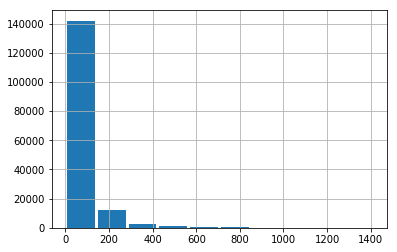

In [10]:
train_word_count.hist(bins=10, rwidth=0.9)

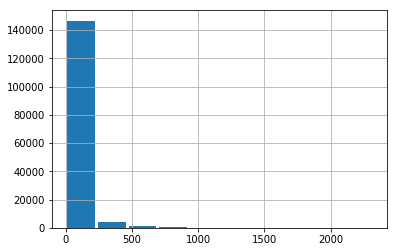

In [11]:
test_word_count.hist(bins=10, rwidth=0.9)

In [12]:
maxlen = 175
print(train_word_count[train_word_count < maxlen].count()/train_word_count.count())
print(test_word_count[test_word_count < maxlen].count()/test_word_count.count())

0.9197974569313974
0.9310020631479983


In [13]:
train_df.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [14]:
test_df.isnull().sum()

id              0
comment_text    0
dtype: int64

In [15]:
max_features = 100000
train_text = train_df['comment_text']

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(train_text.values)

train_sequences = tokenizer.texts_to_sequences(train_text)
train_data = pad_sequences(train_sequences, maxlen=maxlen)

In [16]:
train_text[1]

"D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)"

In [17]:
list(train_sequences[1])

[96145,
 52,
 2635,
 13,
 555,
 3809,
 73,
 4556,
 2706,
 21,
 94,
 38,
 803,
 2679,
 992,
 589,
 8377,
 182]

In [18]:
#Jeremy's Tokenizer
#May want to try this after you get a result

#import re, string
#re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
#def tokenizer(s): return re_tok.sub(r' \1 ', s).split()

In [19]:
label_names = train_df.columns[2:].values; label_names

array(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'], dtype=object)

In [20]:
target = train_df[label_names]
target.shape

(159571, 6)

In [21]:
val_count = 15000

x_val = train_data[:val_count]
x_train = train_data[val_count:]
y_val = target[:val_count]
y_train = target[val_count:]

In [22]:
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(144571, 175) (144571, 6) (15000, 175) (15000, 6)


#### RocAucEvaluation CallBack

In [23]:
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, batch_size=64, verbose=1)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch+1, score))

In [24]:
roc_auc = RocAucEvaluation(validation_data=(x_val, y_val), interval=1)

#### Pre-Trained Emdedding Matrix

In [25]:
class WordEmbeddingsProcessor:
    
    def __init__(self, file_path, max_features, emb_sz, toknzr):
        self.file_path = file_path
        self.max_features = max_features
        self.emb_sz = emb_sz
        self.toknzr = toknzr
        self.embeddings_index = {}
        
    def generate_embeddings_index(self):
        with open(self.file_path, encoding = "utf8", errors = "ignore") as f:
            for line in f:
                values = line.rstrip().rsplit(' ')
                word = values[0]
                coefs = np.asarray(values[1:], dtype='float64')
                self.embeddings_index[word] = coefs
                
    def get_embedding_matrix(self):
        self.generate_embeddings_index()
        
        word_index = self.toknzr.word_index
        num_words = min(self.max_features, len(word_index) + 1)
        embedding_matrix = np.zeros((num_words, self.emb_sz))
        for word, i in word_index.items():
            if i >= self.max_features:
                continue
            embedding_vector = self.embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
                
        return embedding_matrix

In [26]:
emb_sz = 300

fastTextProcessor = WordEmbeddingsProcessor(FASTTEXT_FILE_PATH,max_features=max_features,emb_sz=emb_sz,toknzr=tokenizer)

In [27]:
emb_matrix = fastTextProcessor.get_embedding_matrix()

#### Building Pre-Trained Model With Pre-Emeddings

In [28]:
opt = optimizers.Adam(lr=0.001, beta_1=0.7, beta_2=0.99, epsilon=None, decay=0.0, amsgrad=False)

In [36]:
def build_model():
    inp = Input(shape=(maxlen,))
    x = Embedding(max_features, emb_sz, weights=[emb_matrix], trainable = False)(inp)
    x = SpatialDropout1D(0.3)(x)
    x = Bidirectional(GRU(128, dropout=0.3, recurrent_dropout=0.5,  return_sequences=True))(x)
    #Change arch -> GlobalMax to ->Avg 
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool])
    outp = Dense(6, activation = "sigmoid")(conc)
    ##x = GlobalMaxPooling1D()(x)
    ##x = Dense(6, activation="sigmoid")(x)
    
    ##model = Model(inputs=inp, outputs=x)
    model = Model(inputs = inp, outputs = outp)
    return model

#model = build_model()
#model.compile(optimizer='rmsprop',
#              loss='binary_crossentropy',
#              metrics=['accuracy'])
model = build_model()
model.compile(optimizer= opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 175)          0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 175, 300)     30000000    input_3[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_3 (SpatialDro (None, 175, 300)     0           embedding_3[0][0]                
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 175, 256)     329472      spatial_dropout1d_3[0][0]        
__________________________________________________________________________________________________
global_ave

#### Training

In [57]:
best_weights_path = 'weights_base.best.hdf5'
val_loss_checkpoint = ModelCheckpoint(best_weights_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=12)

In [59]:
model.fit(x_train, y_train,
          epochs=40,
          batch_size=64,
          validation_data=(x_val, y_val),
          callbacks=[roc_auc, val_loss_checkpoint, early_stop], verbose=1)

Train on 144571 samples, validate on 15000 samples
Epoch 1/40
15000/15000 [==============================] - 50s 3ms/step

 ROC-AUC - epoch: 1 - score: 0.988671 


Epoch 00001: val_loss improved from inf to 0.04278, saving model to weights_base.best.hdf5
Epoch 2/40
 95936/144571 [==================>...........] - ETA: 8:33 - loss: 0.0373 - acc: 0.9853

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



15000/15000 [==============================] - 50s 3ms/step

 ROC-AUC - epoch: 4 - score: 0.988474 


Epoch 00004: val_loss did not improve
Epoch 5/40
 99648/144571 [===================>..........] - ETA: 7:54 - loss: 0.0372 - acc: 0.9854

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



15000/15000 [==============================] - 47s 3ms/step

 ROC-AUC - epoch: 7 - score: 0.987690 


Epoch 00007: val_loss did not improve
Epoch 8/40
115904/144571 [=======================>......] - ETA: 4:45 - loss: 0.0410 - acc: 0.9843

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



15000/15000 [==============================] - 47s 3ms/step

 ROC-AUC - epoch: 10 - score: 0.988398 


Epoch 00010: val_loss did not improve
Epoch 11/40
127168/144571 [=========================>....] - ETA: 2:53 - loss: 0.0400 - acc: 0.9845

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



15000/15000 [==============================] - 47s 3ms/step

 ROC-AUC - epoch: 13 - score: 0.988042 


Epoch 00013: val_loss did not improve
Epoch 14/40
138624/144571 [===========================>..] - ETA: 59s - loss: 0.0400 - acc: 0.9846 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [50]:
model.fit(x_train, y_train,
          epochs=1,
          batch_size=64,
          validation_data=(x_val, y_val),
          callbacks=[roc_auc, val_loss_checkpoint, early_stop], verbose=1,
         )

Train on 144571 samples, validate on 15000 samples
Epoch 1/1
15000/15000 [==============================] - 49s 3ms/step

 ROC-AUC - epoch: 1 - score: 0.988865 


Epoch 00001: val_loss did not improve


In [ ]:
pretrained_weights_path = 'tmp/toxic/my_model_bs_64.hdf5'
model.load_weights(pretrained_weights_path)

In [58]:
model.save('tmp/toxic/my_model_bs_64.hdf5')

In [60]:
val_preds = model.predict(x_val, batch_size=64, verbose=1)

15000/15000 [==============================] - 47s 3ms/step


In [61]:
roc_auc_score(y_val, val_preds)

0.9883653581037218

#### Predictions on Test Data

In [62]:
test_sequences = tokenizer.texts_to_sequences(test_df['comment_text'])
x_test = pad_sequences(test_sequences, maxlen=maxlen)

In [ ]:
test_preds = model.predict(x_test, batch_size=64, verbose=1)

142528/153164 [==========================>...] - ETA: 33s

#### Submission

In [ ]:
sub_df = pd.DataFrame(test_preds, columns=label_names)
sub_df.insert(0, 'id', test_df['id'])
sub_df.head()

In [ ]:
sub_df.to_csv(f'{PATH}/models/FINALLY7_bs64.csv', index=None)

In [ ]:
2+1